# Dissimilarity based on multiple-point histogram (MPH) analysis
Multiple-point histograms [Boisvert et al., 2010] are based on pattern recognition. Patterns are delimited by a search window whose dimensionality matches the one of the dataset. One can count unique patterns, however the number of unique patterns might be relatively important, in particular for continuous property fields. In that case, it might require to restrain the analysis to the most frequent patterns [Meerschman et al., 2013]. 
An alternative is to base the analysis on pattern cluster representatives. Here, using k-means clustering, we classify all patterns into $N_c=10$ clusters. Each cluster centroid or barycentre defines its representative.

In addition, voxets can be easily upscaled which allows MPH analysis of potentially large scale features with a small research window at high level of upscaling. Note that a given level $l$ of upscaling, the size of the dataset is divided by $2^l$ along each dimension. Here, to avoid propery values smoothing, we perform a stochastic upscaling, i.e. in a 2D case, the upscaled value of a $2\times2$ subset of pixels is achieved by a uniform random draw among the values of the $4$ pixels. Cluster pattern identification is performed at the initial resolution level ($l=0$) and at all possible upscaled levels.

For a given upscaling level, once k-means clustering of patterns has been performed on two voxets or datasets, distances between cluster representatives of two images can be computed: $d(C_1^i,C_2^j)= \left( \sum \limits_{w=1}^{N_w} (C_1^i(w)-C_2^j(w))^2 \right)^{{1}\over{2}}$, where $C_1^i$ is the $i^{th}$cluster representative for voxet 1, $C_2^j$ is the $j^{th}$cluster representative for voxet 2 and $w$ denotes the index of the window-search elements. <br>

The clusters between two datasets are paired by similarity (smallest distance), and re-orderd such that $\forall i$, $1\leq i \leq N_c$, $C_1^i$ is paired with $C_2^i$. To account for cluster size differences, the distance between paired cluster representative are weighted by proportion dissimilarities. It results in an MPH cluster based distance between voxets/datasets 1 & 2 defined as: 
$$
d_{\text{MPH}}(\text{Voxet}_1,\text{Voxet}_2) = \sum \limits_{i=1}^{N_c} {{1}\over{N_c}} \left[ \left( 1+d(C_1^i,C_2^i) \right) \times \left(1+ {{|p_1^i-p_2^i|}\over{p_1^i+p_2^i}} \right) -1 \right] \text{,} 
$$
where $p_1^i$ and $p_2^i$ are the proportions of the paired clusters $C_1^i$ and $C_2^i$ with respects to voxets 1 & 2 respectively.

*Remark:* one advantage of selecting cluster representative independently between two voxets might is to lower computing requirements over large ensemble of voxets, performing the analysis for $N_v$ voxets instead of  ${{N_v(N_v-1)}\over{2}}$ pairs. However, performing k-means pattern clustering on two datasets might provide a more accurate and precise way to compute a distance between histograms with the same support of cluster representatives, allowing thus the use of Jensen-Shannon divergence for instance. One can note that we accounted for size of the clusters, but we could also consider the density spread or concentration around cluster representatives.

### References
Boisvert, J. B., Pyrcz, M. J., & Deutsch, C. V. (2010). Multiple point metrics to assess categorical variable models. Natural resources research, 19(3), 165-175. http://dx.doi.org/10.1007%2Fs11053-010-9120-2

Meerschman, E., Pirot, G., Mariethoz, G., Straubhaar, J., Van Meirvenne, M., & Renard, P. (2013). A practical guide to performing multiple-point statistical simulations with the Direct Sampling algorithm. Computers & Geosciences, 52, 307-324. https://doi.org/10.1016/j.cageo.2012.09.019

In [1]:
# import modules
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn import manifold
import pickle
from loopui import dist_kmeans_mph

picklefilenamemph = "./pickledata/synthetic-case-mph.pickle"
picklefilenamedata = "./pickledata/synthetic-case-data.pickle"

# plotting parameters
slice_ix=0
slice_iy=0
slice_iz=7
aspectratio = 1 # !! in pixels !!
sample_num1 = 0
sample_num2 = 10

# MPH based dissimilarity parameters
seed = 65432
n_clusters=10
nmax_patterns = int(1E4)
pattern2Dsize = np.asarray([3,4])
pattern3Dsize = np.asarray([1,2,3])

# import data
with open(picklefilenamedata, 'rb') as f:
    [lithocode_100,lithocode_50A,lithocode_50B,scalarfield_100,scalarfield_50A,
     scalarfield_50B,nx,ny,nz,nbsamples,clblab,clblabsf] = pickle.load(f)

# initialization
yyy,zzz,xxx=np.meshgrid(np.arange(1,ny+1),np.flip(np.arange(1,nz+1)),np.arange(1,nx+1))
xx=xxx[slice_iz,:,:]
yy=yyy[slice_iz,:,:]
zz=zzz[slice_iz,:,:]
maxh3D = np.sqrt(nx**2+ny**2+nz**2)/3
maxh2D = np.sqrt(nx**2+ny**2)/3

lithocode_all = np.reshape(np.stack((lithocode_100,lithocode_50A,lithocode_50B),axis=4),(nz,ny,nx,nbsamples*3),order='F')
scalarfield_all = np.reshape(np.stack((scalarfield_100,scalarfield_50A,scalarfield_50B),axis=4),(nz,ny,nx,nbsamples*3),order='F')

# load classes
categval = np.unique(lithocode_all)

# maximum number of upscaling levels
max2Dlevels = np.min([np.floor(np.log(ny/(pattern2Dsize[0]+n_clusters**(1/2))) / np.log(2) ),
                      np.floor(np.log(nx/(pattern2Dsize[1]+n_clusters**(1/2))) / np.log(2) )]).astype(int)
freedomX = nx/2**(max2Dlevels+1)-pattern2Dsize[1]
freedomY = ny/2**(max2Dlevels+1)-pattern2Dsize[0]
if freedomX*freedomY>=n_clusters:
    max2Dlevels +=1
    
max3Dlevels = np.min([np.floor(np.log(nz/(pattern3Dsize[0]+n_clusters**(1/3)))/np.log(2)),
                      np.floor(np.log(ny/(pattern3Dsize[1]+n_clusters**(1/3)))/np.log(2)),
                      np.floor(np.log(nx/(pattern3Dsize[2]+n_clusters**(1/3)))/np.log(2))]).astype(int)
freedomX = nx/2**(max3Dlevels+1)-pattern3Dsize[2]
freedomY = ny/2**(max3Dlevels+1)-pattern3Dsize[1]
freedomZ = nz/2**(max3Dlevels+1)-pattern3Dsize[0]
if freedomX*freedomY*freedomZ>=n_clusters:
    max3Dlevels +=1


## 2D case
For each level of upscaling, 2 plots are rendered. One uses an independent colorscale for each pattern, the other one uses a shared colorscale. For each plot, the upperleft corner displays the 2D voxet of dataset 1 called img1 at the given level of upscaling ; the bottom left corner displays the 2D voxet of dataset 2 called img2; the upper right corner shows the patterns of the 10 cluster representatives for img1 with their size ; the lower right corner shows the patterns of the 10 cluster representatives for img2 with their size.

29-Jun-2022 (20:04:36) - COMPUTING k-means clustered MPH BASED DIST 2D START
Level 0
Number of possible patterns: 11100
Number of sub-sampled patterns: 10000
Distance component: 13629.479806866757


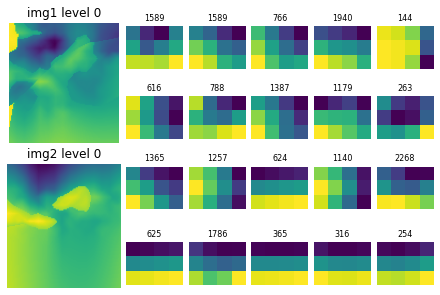

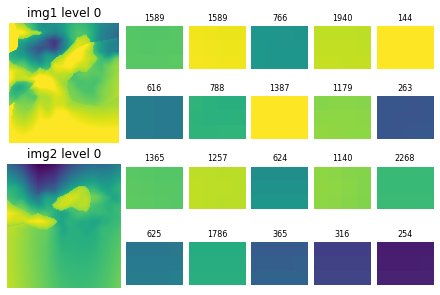

Level 1
Number of possible patterns: 2592
Number of sub-sampled patterns: 2592
Distance component: 12575.49215696203


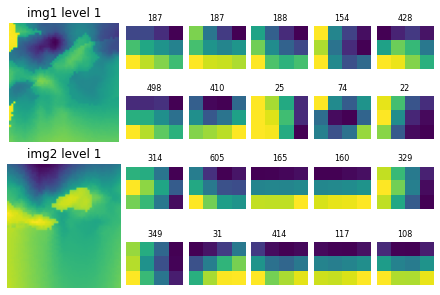

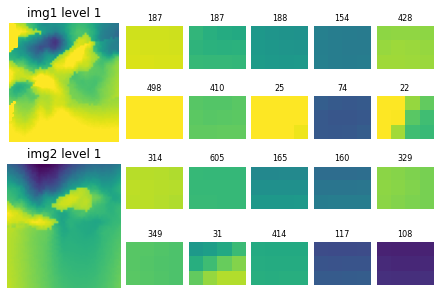

Level 2
Number of possible patterns: 572
Number of sub-sampled patterns: 572
Distance component: 13010.171451787666


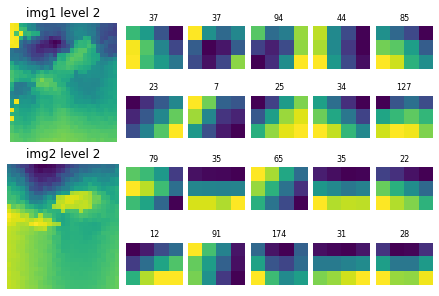

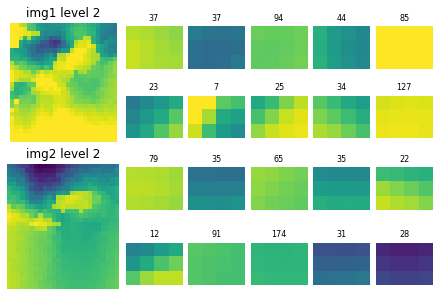

Level 3
Number of possible patterns: 108
Number of sub-sampled patterns: 108
Distance component: 19178.586616815555


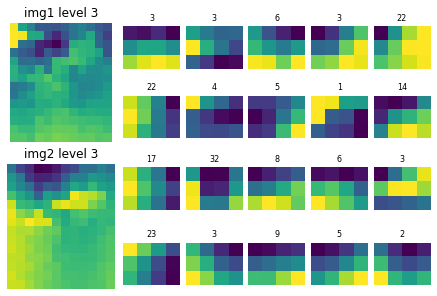

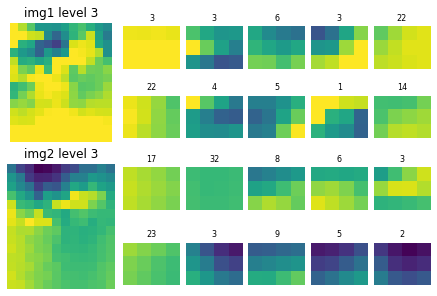

Level 4
Number of possible patterns: 15
Number of sub-sampled patterns: 15
Distance component: 13823.918531958876


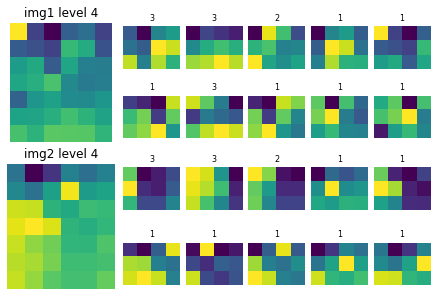

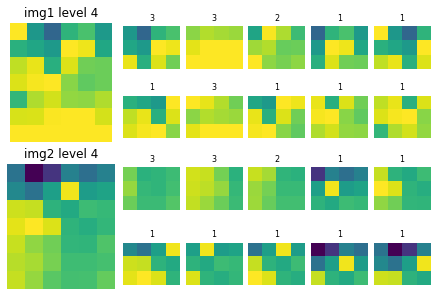

29-Jun-2022 (20:04:52) - COMPUTING k-means clustered MPH BASED DIST 2D END


In [2]:
img1 = scalarfield_all[slice_iz,:,:,sample_num1] # for illustration, we consider the magnetic response of random sample #9
img2 = scalarfield_all[slice_iz,:,:,sample_num2] # for illustration, we consider the magnetic response of random sample #2

n_levels=max2Dlevels+1
patternsize=pattern2Dsize

print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING k-means clustered MPH BASED DIST 2D START")
d = dist_kmeans_mph(img1,img2,n_levels,patternsize,n_clusters,nmax_patterns,seed,plot=True,verb=True)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING k-means clustered MPH BASED DIST 2D END")


## 3D case
For each level of upscaling, 2 plots are rendered. One uses an independent colorscale for each pattern, the other one uses a shared colorscale.

In [3]:

img1 = lithocode_all[slice_iz:,:,:,sample_num1] # for illustration, we consider the magnetic response of random sample #9
img2 = lithocode_all[slice_iz:,:,:,sample_num2] # for illustration, we consider the magnetic response of random sample #2

n_levels=max3Dlevels
patternsize=pattern3Dsize

print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING k-means clustered MPH BASED DIST 3D categ START")
d = dist_kmeans_mph(img1,img2,n_levels,patternsize,n_clusters,nmax_patterns,seed,plot=False,verb=True)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING k-means clustered MPH BASED DIST 3D categ END")


29-Jun-2022 (20:04:52) - COMPUTING k-means clustered MPH BASED DIST 3D categ START
Level 0
Number of possible patterns: 294112
Number of sub-sampled patterns: 10000
Distance component: 16.801767526457947
Level 1
Number of possible patterns: 35035
Number of sub-sampled patterns: 10000
Distance component: 12.86313541356297
Level 2
Number of possible patterns: 3726
Number of sub-sampled patterns: 3726
Distance component: 20.73114465478978
Level 3
Number of possible patterns: 390
Number of sub-sampled patterns: 390
Distance component: 26.62065227950575
Level 4
Number of possible patterns: 24
Number of sub-sampled patterns: 24
Distance component: 25.449757898013715
29-Jun-2022 (20:04:55) - COMPUTING k-means clustered MPH BASED DIST 3D categ END


## Compute for all pair of voxets<span style='color:red'>\*</span>
<span style='color:red'>**\*WARNING: IT COULD TAKE AROUND 44 MINUTES. PRECOMPUTED RESULTS ALREADY AVAILABLE IN THE PICKLE FOLDER** </span>

In [4]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING MULTIPLE-POINT HISTOGRAM BASED DIST ALL START")

dist_mph_lc = np.zeros((3*nbsamples,3*nbsamples))
dist_mph_sf = np.zeros((3*nbsamples,3*nbsamples))

k=0
for i in range(3*nbsamples):
    for j in range(i):
        k+=1
        print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+'k = '+str(k)+' - i = '+str(i)+' j = ',str(j))
        dist_mph_lc[i,j] = dist_kmeans_mph(lithocode_all[slice_iz:,:,:,i],lithocode_all[slice_iz:,:,:,j],max3Dlevels,pattern3Dsize,n_clusters,nmax_patterns,seed)
        dist_mph_sf[i,j] = dist_kmeans_mph(scalarfield_all[slice_iz:,:,:,i],scalarfield_all[slice_iz:,:,:,j],max3Dlevels,pattern3Dsize,n_clusters,nmax_patterns,seed)
        dist_mph_lc[j,i] = dist_mph_lc[i,j]
        dist_mph_sf[j,i] = dist_mph_sf[i,j]

print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING MULTIPLE-POINT HISTOGRAM BASED DIST ALL END")


29-Jun-2022 (20:04:55) - COMPUTING MULTIPLE-POINT HISTOGRAM BASED DIST ALL START
29-Jun-2022 (20:04:55) - k = 1 - i = 1 j =  0
29-Jun-2022 (20:05:03) - k = 2 - i = 2 j =  0
29-Jun-2022 (20:05:09) - k = 3 - i = 2 j =  1
29-Jun-2022 (20:05:16) - k = 4 - i = 3 j =  0
29-Jun-2022 (20:05:22) - k = 5 - i = 3 j =  1
29-Jun-2022 (20:05:29) - k = 6 - i = 3 j =  2
29-Jun-2022 (20:05:35) - k = 7 - i = 4 j =  0
29-Jun-2022 (20:05:42) - k = 8 - i = 4 j =  1
29-Jun-2022 (20:05:51) - k = 9 - i = 4 j =  2
29-Jun-2022 (20:06:00) - k = 10 - i = 4 j =  3
29-Jun-2022 (20:06:08) - k = 11 - i = 5 j =  0
29-Jun-2022 (20:06:15) - k = 12 - i = 5 j =  1
29-Jun-2022 (20:06:25) - k = 13 - i = 5 j =  2
29-Jun-2022 (20:06:32) - k = 14 - i = 5 j =  3
29-Jun-2022 (20:06:39) - k = 15 - i = 5 j =  4
29-Jun-2022 (20:06:47) - k = 16 - i = 6 j =  0
29-Jun-2022 (20:06:56) - k = 17 - i = 6 j =  1
29-Jun-2022 (20:07:06) - k = 18 - i = 6 j =  2
29-Jun-2022 (20:07:13) - k = 19 - i = 6 j =  3
29-Jun-2022 (20:07:20) - k = 20 - i

29-Jun-2022 (20:23:47) - k = 169 - i = 18 j =  15
29-Jun-2022 (20:23:53) - k = 170 - i = 18 j =  16
29-Jun-2022 (20:24:01) - k = 171 - i = 18 j =  17
29-Jun-2022 (20:24:06) - k = 172 - i = 19 j =  0
29-Jun-2022 (20:24:12) - k = 173 - i = 19 j =  1
29-Jun-2022 (20:24:18) - k = 174 - i = 19 j =  2
29-Jun-2022 (20:24:24) - k = 175 - i = 19 j =  3
29-Jun-2022 (20:24:31) - k = 176 - i = 19 j =  4
29-Jun-2022 (20:24:39) - k = 177 - i = 19 j =  5
29-Jun-2022 (20:24:45) - k = 178 - i = 19 j =  6
29-Jun-2022 (20:24:52) - k = 179 - i = 19 j =  7
29-Jun-2022 (20:25:01) - k = 180 - i = 19 j =  8
29-Jun-2022 (20:25:08) - k = 181 - i = 19 j =  9
29-Jun-2022 (20:25:15) - k = 182 - i = 19 j =  10
29-Jun-2022 (20:25:21) - k = 183 - i = 19 j =  11
29-Jun-2022 (20:25:27) - k = 184 - i = 19 j =  12
29-Jun-2022 (20:25:33) - k = 185 - i = 19 j =  13
29-Jun-2022 (20:25:38) - k = 186 - i = 19 j =  14
29-Jun-2022 (20:25:44) - k = 187 - i = 19 j =  15
29-Jun-2022 (20:25:50) - k = 188 - i = 19 j =  16
29-Jun-202

29-Jun-2022 (20:42:44) - k = 335 - i = 26 j =  9
29-Jun-2022 (20:42:51) - k = 336 - i = 26 j =  10
29-Jun-2022 (20:42:58) - k = 337 - i = 26 j =  11
29-Jun-2022 (20:43:06) - k = 338 - i = 26 j =  12
29-Jun-2022 (20:43:12) - k = 339 - i = 26 j =  13
29-Jun-2022 (20:43:19) - k = 340 - i = 26 j =  14
29-Jun-2022 (20:43:26) - k = 341 - i = 26 j =  15
29-Jun-2022 (20:43:32) - k = 342 - i = 26 j =  16
29-Jun-2022 (20:43:38) - k = 343 - i = 26 j =  17
29-Jun-2022 (20:43:45) - k = 344 - i = 26 j =  18
29-Jun-2022 (20:43:51) - k = 345 - i = 26 j =  19
29-Jun-2022 (20:43:57) - k = 346 - i = 26 j =  20
29-Jun-2022 (20:44:04) - k = 347 - i = 26 j =  21
29-Jun-2022 (20:44:11) - k = 348 - i = 26 j =  22
29-Jun-2022 (20:44:17) - k = 349 - i = 26 j =  23
29-Jun-2022 (20:44:23) - k = 350 - i = 26 j =  24
29-Jun-2022 (20:44:30) - k = 351 - i = 26 j =  25
29-Jun-2022 (20:44:36) - k = 352 - i = 27 j =  0
29-Jun-2022 (20:44:42) - k = 353 - i = 27 j =  1
29-Jun-2022 (20:44:48) - k = 354 - i = 27 j =  2
29-J

## Some Multi-Dimensional Scaling plots<span style='color:red'>\*</span>
<span style='color:red'>**\*if all pairs of distances have been computed** </span>

29-Jun-2022 (20:53:32) - COMPUTING 2D MDS REPRESENTATION START


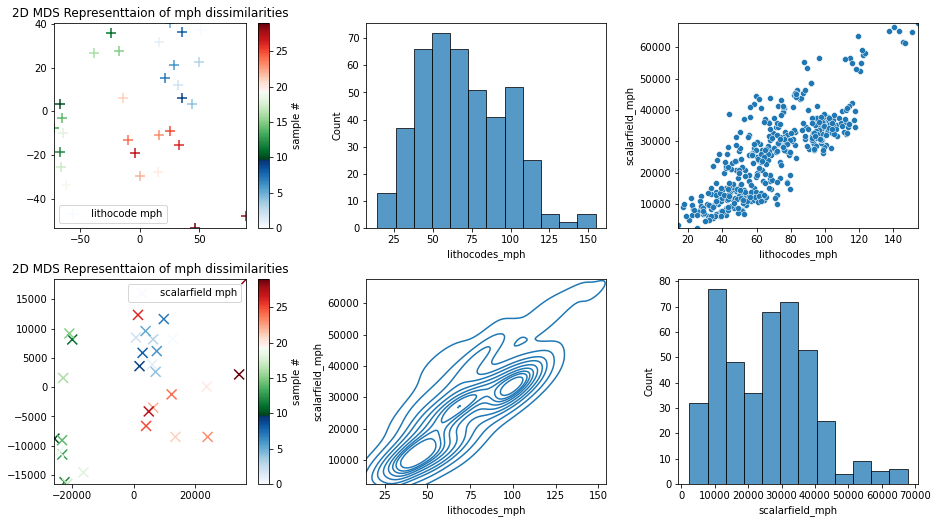

29-Jun-2022 (20:53:35) - COMPUTING 2D MDS REPRESENTATION END


In [5]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D MDS REPRESENTATION START")
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

mdspos_lc = mds.fit(dist_mph_lc).embedding_
mdspos_sf = mds.fit(dist_mph_sf).embedding_

s_id = np.arange(nbsamples*3)
# Plot concentric circle dataset
colors1 = plt.cm.Blues(np.linspace(0., 1, 512))
colors2 = np.flipud(plt.cm.Greens(np.linspace(0, 1, 512)))
colors3 = plt.cm.Reds(np.linspace(0, 1, 512))
colors = np.vstack((colors1, colors2, colors3))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

ix=np.tril_indices(nbsamples*3,k=-1)
df= pd.DataFrame({'lithocodes_mph':dist_mph_lc[ix], 'scalarfield_mph':dist_mph_sf[ix]})

lcmin = np.amin(dist_mph_lc[ix]) 
lcmax = np.amax(dist_mph_lc[ix])
sfmin = np.amin(dist_mph_sf[ix]) 
sfmax = np.amax(dist_mph_sf[ix])

lcMDSxmin = np.min(mdspos_lc[:,0])
lcMDSxmax = np.max(mdspos_lc[:,0])
lcMDSymin = np.min(mdspos_lc[:,1])
lcMDSymax = np.max(mdspos_lc[:,1])

sfMDSxmin = np.min(mdspos_sf[:,0])
sfMDSxmax = np.max(mdspos_sf[:,0])
sfMDSymin = np.min(mdspos_sf[:,1])
sfMDSymax = np.max(mdspos_sf[:,1])

s = 100
fig = plt.figure()
plt.subplot(231)
plt.title('2D MDS Representtaion of mph dissimilarities')
plt.scatter(mdspos_lc[:, 0], mdspos_lc[:, 1], c=s_id,cmap=mycmap, s=s, label='lithocode mph', marker='+')
plt.xlim(lcMDSxmin,lcMDSxmax)
plt.ylim(lcMDSymin,lcMDSymax)
plt.legend(scatterpoints=1, loc='best', shadow=False)
cbar = plt.colorbar()
cbar.set_label('sample #')
plt.subplot(234)
plt.title('2D MDS Representtaion of mph dissimilarities')
plt.scatter(mdspos_sf[:, 0], mdspos_sf[:, 1], c=np.arange(nbsamples*3),cmap=mycmap, s=s, label='scalarfield mph', marker='x')
plt.xlim(sfMDSxmin,sfMDSxmax)
plt.ylim(sfMDSymin,sfMDSymax)
plt.legend(scatterpoints=1, loc='best', shadow=False)
cbar = plt.colorbar()
cbar.set_label('sample #')
plt.subplot(232)
sns.histplot(df.lithocodes_mph)
plt.subplot(233)
sns.scatterplot(x=df.lithocodes_mph,y=df.scalarfield_mph)
plt.xlim(lcmin,lcmax)
plt.ylim(sfmin,sfmax)
plt.subplot(235)
sns.kdeplot(x=df.lithocodes_mph,y=df.scalarfield_mph)
plt.xlim(lcmin,lcmax)
plt.ylim(sfmin,sfmax)
plt.subplot(236)
sns.histplot(df.scalarfield_mph)
fig.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.6, wspace=0.3, hspace=0.25)
plt.show()

print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D MDS REPRESENTATION END")

## Save indicators<span style='color:red'>\*</span>
<span style='color:red'>**\*if all pairs of distances have been computed** </span>

In [6]:
with open(picklefilenamemph, 'wb') as f:
    pickle.dump([dist_mph_lc,dist_mph_sf], f)
